In [82]:
from urllib.request import urlretrieve
import tarfile 
import pandas as pd
import uuid
import hashlib
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns

## Downloading the dataset

In [83]:
ham_link='https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2'
spam_link='https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2'

urlretrieve(ham_link, 'easy_ham.tar.bz2')
urlretrieve(spam_link, 'spam.tar.bz2')

ham_file = tarfile.open('easy_ham.tar.bz2', 'r:bz2') 
spam_file = tarfile.open('spam.tar.bz2', 'r:bz2')

ham_file.extractall('data') 
spam_file.extractall('data')
ham_file.close() 
spam_file.close()

/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2953/2416473435.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  ham_file.extractall('data')
/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2953/2416473435.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  spam_file.extractall('data')


## Loading the data

In [84]:
# Loading the files in the data folder
import os

ham_filenames = [name for name in sorted(os.listdir('data/easy_ham')) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir('data/spam')) if len(name) > 20]

print('Number of ham files:', len(ham_filenames))
print('Number of spam files:', len(spam_filenames))

df = pd.DataFrame(ham_filenames + spam_filenames, columns=['email_id'])

def to_uuid(id_str):
    # Create a SHA-256 hash and return the first 16 hex characters
    return hashlib.sha256(id_str.encode()).hexdigest()[:16]

# Convert all file names to UUIDs
df['email_id'] = df['email_id'].apply(to_uuid)
df.head()

# Pre-calculate the ham UUIDs for correct spam flag assignment
ham_uuids = [to_uuid(name) for name in ham_filenames]
df['is_spam'] = df['email_id'].apply(lambda x: 0 if x in ham_uuids else 1)
df.head()

contents = []

def read_file_and_append(filepath):
    with open(filepath, 'rb') as f:
        contents.append(f.read().decode('latin1'))

# Reading ham files
for filename in ham_filenames:
    read_file_and_append(os.path.join('data', 'easy_ham', filename))

# Reading spam files
for filename in spam_filenames:
    read_file_and_append(os.path.join('data', 'spam', filename))

df['content'] = contents
df.head()

Number of ham files: 2551
Number of spam files: 501


,email_id,is_spam,content
0,98e7e744d4b0ea78,0,From exmh-workers-admin@redhat.com Thu Aug 22...
1,e953def9713ad64f,0,From Steve_Burt@cursor-system.com Thu Aug 22 ...
2,a9c3be24be981dbe,0,From timc@2ubh.com Thu Aug 22 13:52:59 2002\n...
3,1874bd560ea2aaa8,0,From irregulars-admin@tb.tf Thu Aug 22 14:23:...
4,976351ae57c8b54c,0,From exmh-users-admin@redhat.com Thu Aug 22 1...


## Defining Feautures

In [85]:
df['sender'] = df['content'].apply(lambda x: x.split("From " or "from")[1].split()[0] if "From " in x else None)
df['subject'] = df['content'].apply(lambda x: x.split("Subject: ")[1].split("\n")[0] if "Subject: " in x else None)
df['date'] = df['content'].apply(lambda x: x.split("Date: ")[1].split("\n")[0] if "Date: " in x else None)
df['content-type'] = df['content'].apply(lambda x: x.split("Content-Type: ")[1].split("\n")[0] if "Content-Type: " in x else None)
df['content'] = df['content'].apply(lambda x: x.split("\n\n")[1] if "\n\n" in x else None)
df.head()

,email_id,is_spam,content,sender,subject,date,content-type
0,98e7e744d4b0ea78,0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",exmh-workers-admin@redhat.com,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",text/plain; charset=us-ascii
1,e953def9713ad64f,0,"Martin A posted:\nTassos Papadopoulos, the Gre...",Steve_Burt@cursor-system.com,[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",text/plain; charset=US-ASCII
2,a9c3be24be981dbe,0,Man Threatens Explosion In Moscow,timc@2ubh.com,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",text/plain; charset=US-ASCII
3,1874bd560ea2aaa8,0,Klez: The Virus That Won't Die\n \nAlready the...,irregulars-admin@tb.tf,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400","text/plain; charset=""us-ascii"""
4,976351ae57c8b54c,0,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrote:",exmh-users-admin@redhat.com,Re: Insert signature,"Thu, 22 Aug 2002 23:36:32 +1000",None


## converting time to unix timestamp

In [86]:
import re
from datetime import datetime

# Extract time of day from date strings
import email.utils

def extract_time_of_day(date_str):
    """Extract the hour (0-23) from a date string."""
    if pd.isna(date_str):
        return None
    
    try:
        # First try parsing with email.utils for standard email date formats
        try:
            parsed_date = email.utils.parsedate_tz(date_str)
            if parsed_date:
                # parsedate_tz returns a tuple, with hours at index 3
                return parsed_date[3]
        except:
            pass
        
        # Try to find hour:minute pattern in the string
        match = re.search(r'(\d{1,2}):\d{1,2}:\d{1,2}', date_str)
        if match:
            return int(match.group(1))
        
        match = re.search(r'(\d{1,2}):\d{1,2}', date_str)
        if match:
            return int(match.group(1))
        
        # If all else fails, try datetime parsing with common formats
        for fmt in ('%a, %d %b %Y %H:%M:%S %z', '%d %b %Y %H:%M:%S %z'):
            try:
                dt = datetime.strptime(date_str, fmt)
                return dt.hour
            except ValueError:
                continue
        
        return None  # If no pattern matched
    except:
        return None  # Return None for any errors

# Apply the function to create time_of_day column
df['time_of_day'] = df['date'].apply(extract_time_of_day)


Checking for missing values

In [87]:
for col in df.columns:
    print(f'{col}: {df[col].isnull().sum()} missing values')

email_id: 0 missing values
is_spam: 0 missing values
content: 1 missing values
sender: 175 missing values
subject: 1 missing values
date: 1 missing values
content-type: 435 missing values
time_of_day: 1 missing values


## Cleaning the data


In [88]:
# Handling missing values
df['sender'].fillna('unknown', inplace=True)
df['subject'].fillna('unknown', inplace=True)
df['content-type'].fillna('unknown', inplace=True)
df['content'].fillna('unknown', inplace=True)
df['time_of_day'].fillna(-1, inplace=True)  # Fill missing time values with -1

# Create additional features needed for later visualizations
df['content_length'] = df['content'].str.len()
df['subject_length'] = df['subject'].str.len()

# Clip extreme values to reduce impact of outliers
df['content_length'] = df['content_length'].clip(upper=df['content_length'].quantile(0.99))
df['subject_length'] = df['subject_length'].clip(upper=df['subject_length'].quantile(0.99))

df.head()

/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2953/3343840763.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sender'].fillna('unknown', inplace=True)
/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2953/3343840763.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,email_id,is_spam,content,sender,subject,date,content-type,time_of_day,content_length,subject_length
0,98e7e744d4b0ea78,0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",exmh-workers-admin@redhat.com,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",text/plain; charset=us-ascii,18.0,184,24.0
1,e953def9713ad64f,0,"Martin A posted:\nTassos Papadopoulos, the Gre...",Steve_Burt@cursor-system.com,[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",text/plain; charset=US-ASCII,12.0,502,25.0
2,a9c3be24be981dbe,0,Man Threatens Explosion In Moscow,timc@2ubh.com,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",text/plain; charset=US-ASCII,13.0,34,25.0
3,1874bd560ea2aaa8,0,Klez: The Virus That Won't Die\n \nAlready the...,irregulars-admin@tb.tf,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400","text/plain; charset=""us-ascii""",9.0,101,37.0
4,976351ae57c8b54c,0,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrote:",exmh-users-admin@redhat.com,Re: Insert signature,"Thu, 22 Aug 2002 23:36:32 +1000",unknown,23.0,48,20.0


# Shuffling and splitting

In [89]:
# Shuffle the dataframe with a seed for reproducibility
df = df.sample(frac=1, random_state=19).reset_index(drop=True)

# define the features and target
X=df.drop('is_spam', axis=1)
y=df['is_spam']

# Split the dataframe into 80% train and 20% test
split_ratio = 0.8
split_point = int(len(df) * split_ratio)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]


print("Train set head:")
X.head(10)

Train set head:


,email_id,content,sender,subject,date,content-type,time_of_day,content_length,subject_length
0,f5c24751e33f7f9f,\n--sHrvAb52M6C8blB9\nContent-Type: text/plain...,spamassassin-devel-admin@lists.sourceforge.net,Re: [SAdev] [Bug 840] spam_level_char option c...,"Fri, 6 Sep 2002 13:56:19 -0400",multipart/signed; micalg=pgp-sha1;,13.0,134,59.0
1,07811e97f4ec9158,"<html>\n<TABLE id=AutoNumber2 style=""BORDER-CO...",Special_Offer-09192002-HTML@frugaljoe.330w.com,Unleash your PC's Multimedia POWER at 70% off ...,"Thu, 19 Sep 2002 16:28:25 -0400",text/html,16.0,3710,53.0
2,f5ce764d84c449e9,\n--qcHopEYAB45HaUaB\nContent-Type: text/plain...,felicity@kluge.net,Re: [SAtalk] telesp.net.br?,"Sun, 22 Sep 2002 12:38:20 -0400",multipart/signed; micalg=pgp-sha1;,12.0,134,27.0
3,a6cd75e78183dd4e,> If the text recognition algorithm/architectu...,fork-admin@xent.com,"RE: dylsexics of the wrold, untie!","Thu, 12 Sep 2002 16:32:52 -0400","text/plain; charset=""iso-8859-1""",16.0,502,34.0
4,4bd9b1bd6e314efd,"On Wed, 11 Sep 2002, Stephane Lentz wrote:",spamassassin-talk-admin@lists.sourceforge.net,Re: [SAtalk] Re: [SAdev] File::Spec and v2.41,"Wed, 11 Sep 2002 13:46:19 -0700 (PDT)",TEXT/PLAIN; charset=US-ASCII,13.0,42,45.0
5,b5df7345a7403b13,URL: http://boingboing.net/#85524581\nDate: No...,rssfeeds@jmason.org,Gaiman kicks McFarlane's ass in court,"Sat, 05 Oct 2002 08:00:32 -0000",text/plain; encoding=utf-8,8.0,55,37.0
6,760aa2bcb34189a8,"URL: http://www.newsisfree.com/click/-6,810696...",rssfeeds@jmason.org,Radio gives mighty roar to quiet cars,"Thu, 26 Sep 2002 15:32:26 -0000",text/plain; encoding=utf-8,15.0,72,37.0
7,e0c996baee731579,URL: http://diveintomark.org/archives/2002/09/...,rssfeeds@jmason.org,New toys,"Tue, 24 Sep 2002 08:00:02 -0000",text/plain; encoding=utf-8,8.0,94,8.0
8,f08f7069ae8a263a,\nTheo Van Dinter said:,spamassassin-devel-admin@lists.sourceforge.net,Re: [SAdev] 2.40 RELEASE PROCESS: mass-check s...,"Thu, 22 Aug 2002 18:30:45 +0100",unknown,18.0,22,59.0
9,b7e7b2e36a5c2be0,\n<html><body><center>,akad5@excite.com,University Diplomas,"Wed, 11 Sep 2002 09:41:51 -1900","text/html; charset=""iso-8859-1""",9.0,21,19.0


### Let's analyze the data

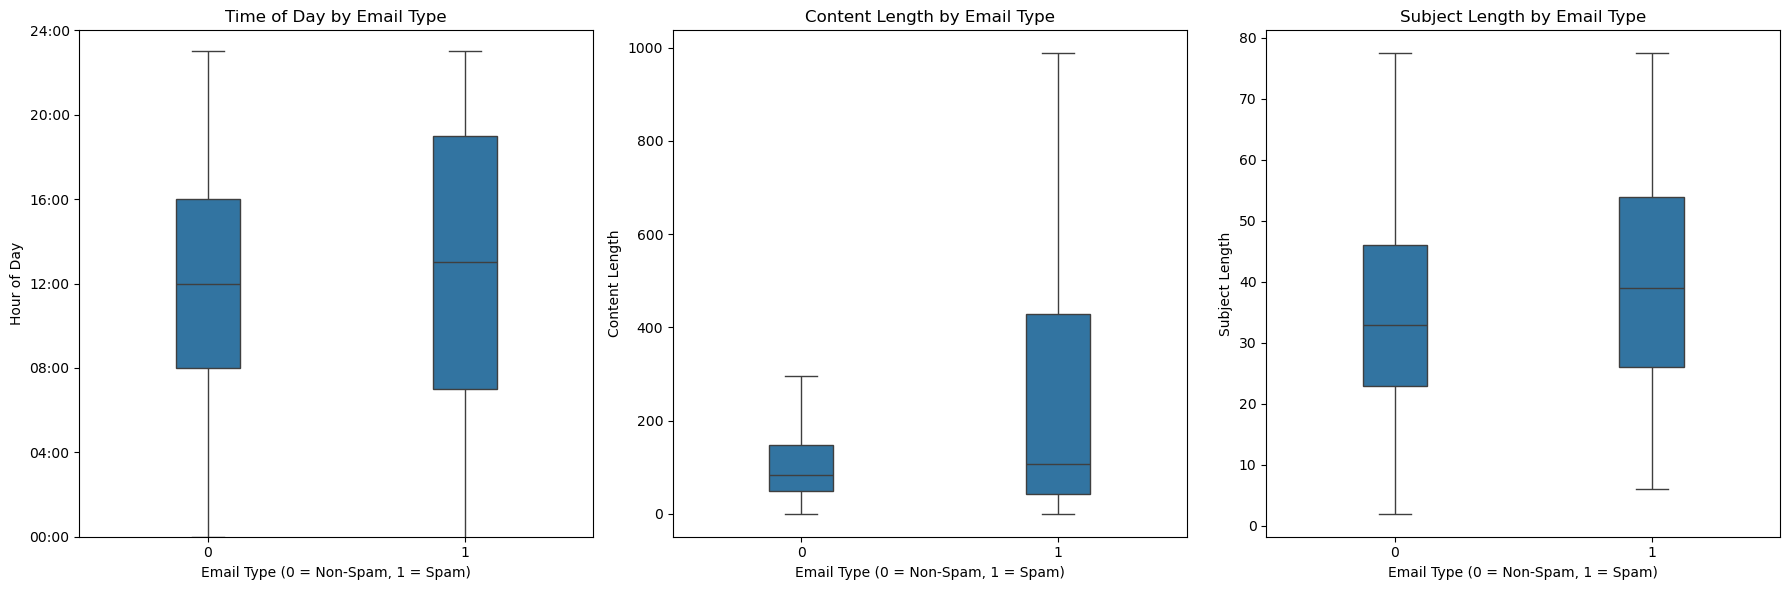

In [90]:
# First, ensure time_of_day is properly stored as float
if df['time_of_day'].dtype != 'float64':
    df['time_of_day'] = df['time_of_day'].astype(float)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Fix time of day plot
sns.boxplot(x='is_spam', y='time_of_day', data=df, ax=axes[0], showfliers=False, width=0.25)
axes[0].set_title('Time of Day by Email Type')
axes[0].set_xlabel('Email Type (0 = Non-Spam, 1 = Spam)')
axes[0].set_ylabel('Hour of Day')
axes[0].set_ylim(0, 24)  # Set limits to 0-24 hours
axes[0].set_yticks(range(0, 25, 4))  # Show ticks at 0, 4, 8, 12, 16, 20, 24
axes[0].set_yticklabels([f"{h:02d}:00" for h in range(0, 25, 4)])  # Format as HH:00

# Content length plot
sns.boxplot(x='is_spam', y='content_length', data=df, ax=axes[1], showfliers=False, width=0.25) 
axes[1].set_title('Content Length by Email Type')
axes[1].set_xlabel('Email Type (0 = Non-Spam, 1 = Spam)')
axes[1].set_ylabel('Content Length')

# Subject length plot
sns.boxplot(x='is_spam', y='subject_length', data=df, ax=axes[2], width=0.25)    
axes[2].set_title('Subject Length by Email Type')
axes[2].set_xlabel('Email Type (0 = Non-Spam, 1 = Spam)')
axes[2].set_ylabel('Subject Length')

plt.tight_layout()
plt.show()

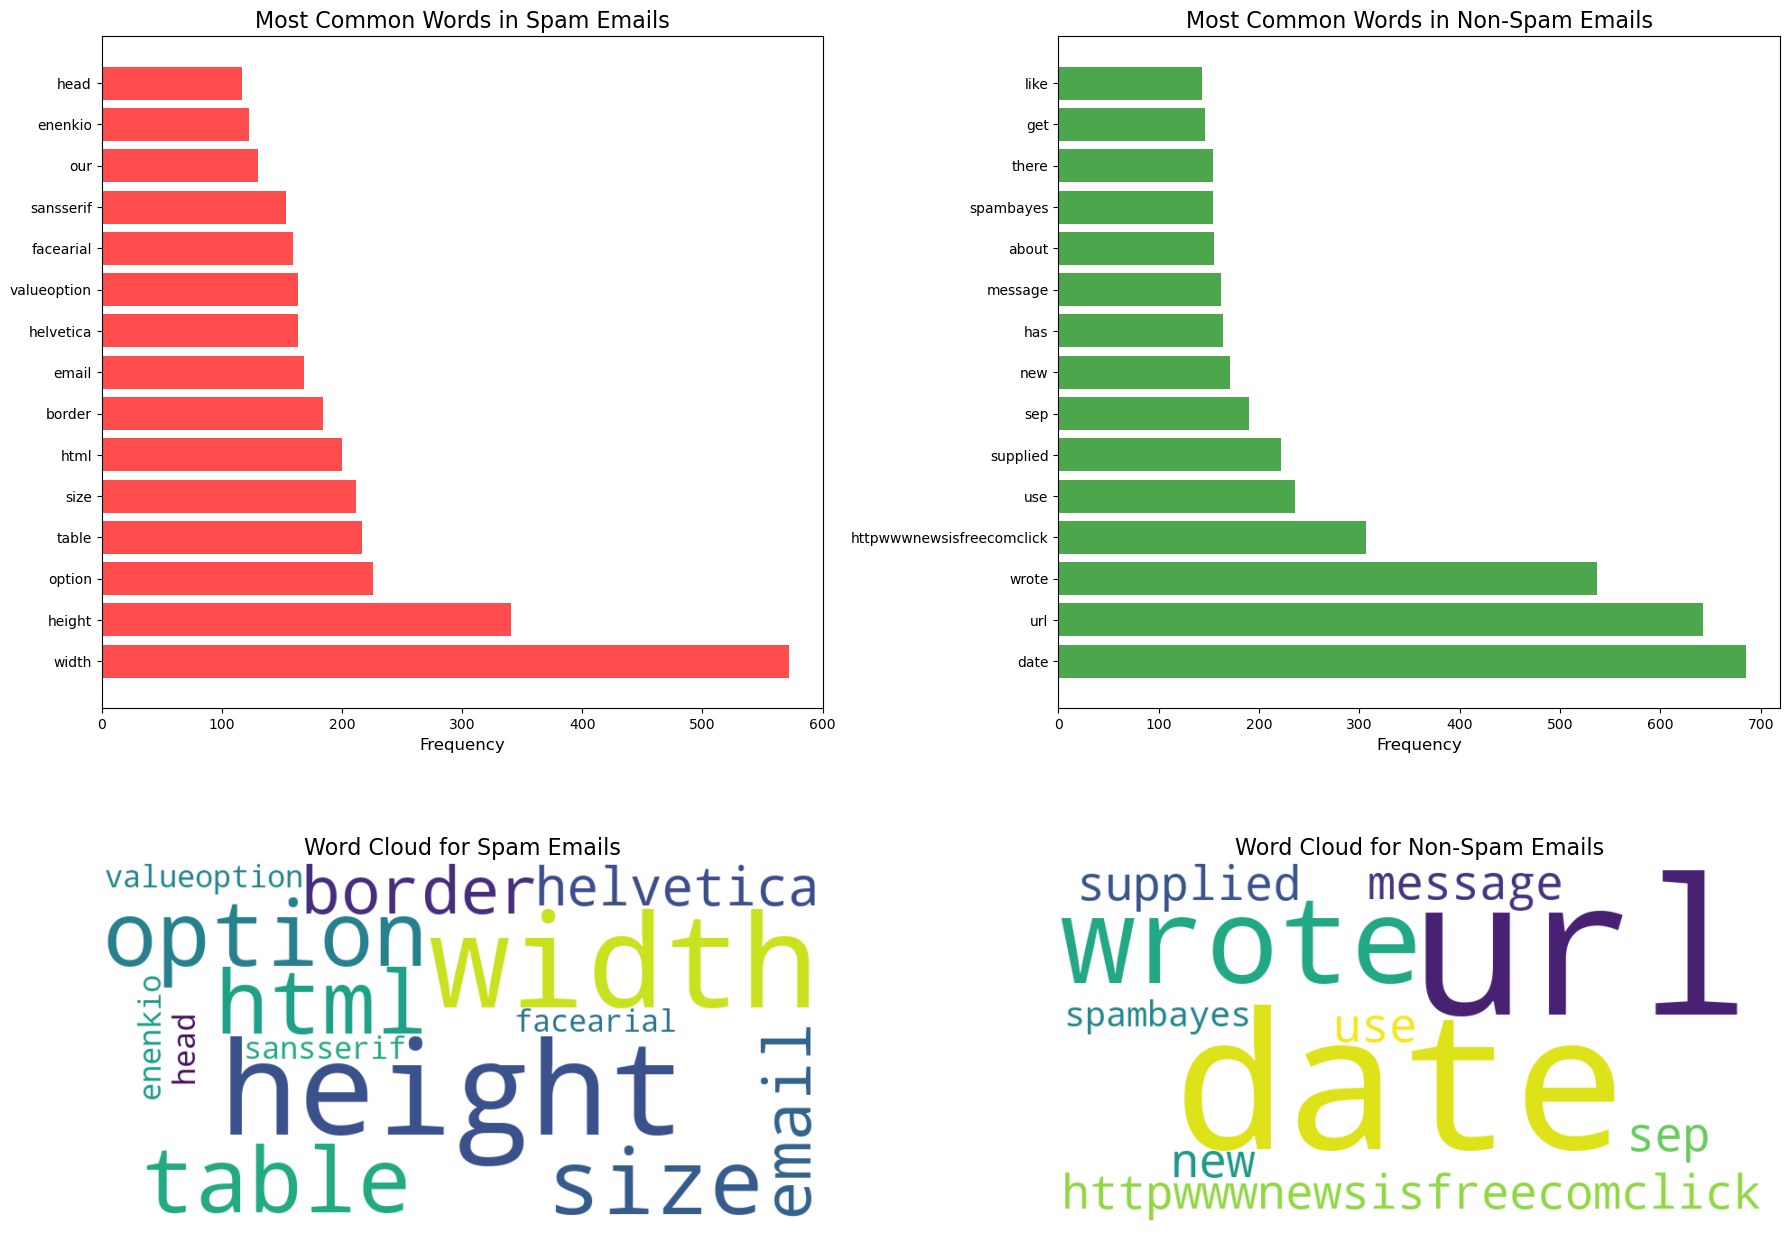

In [91]:
from collections import Counter
import re
from wordcloud import WordCloud
import numpy as np

# Analyze most common words in spam vs non-spam emails
import matplotlib.pyplot as plt

# Function to clean and tokenize text
def clean_text(text):
    if isinstance(text, str):
        # Remove non-alphanumeric characters and convert to lowercase
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        # Split into words and filter out short words (likely not meaningful)
        return [word for word in text.split() if len(word) > 2]
    return []

# Combine content and subject for analysis
df['text_for_analysis'] = df['content'] + ' ' + df['subject']

# Separate spam and ham content
spam_text = ' '.join(df[df['is_spam'] == 1]['text_for_analysis'])
ham_text = ' '.join(df[df['is_spam'] == 0]['text_for_analysis'])

# Clean and tokenize
spam_words = clean_text(spam_text)
ham_words = clean_text(ham_text)

# Get word frequency counts
spam_word_counts = Counter(spam_words)
ham_word_counts = Counter(ham_words)

# Remove common English stopwords not caught by the basic cleaning
stop_words = ['the', 'and', 'this', 'that', 'with', 'from', 'your', 'have', 'for', 
              'not', 'are', 'you', 'any', 'was', 'but', 'what', 'all', 'when',
              'can', 'will', 'just', 'been', 'other', 'they', 'their', 'some']

for word in stop_words:
    spam_word_counts.pop(word, None)
    ham_word_counts.pop(word, None)

# Get most common words
most_common_spam = spam_word_counts.most_common(15)
most_common_ham = ham_word_counts.most_common(15)

# Create figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot spam word frequency
spam_words, spam_counts = zip(*most_common_spam)
axes[0, 0].barh(spam_words, spam_counts, color='red', alpha=0.7)
axes[0, 0].set_title('Most Common Words in Spam Emails', fontsize=16)
axes[0, 0].set_xlabel('Frequency', fontsize=12)

# Plot ham word frequency
ham_words, ham_counts = zip(*most_common_ham)
axes[0, 1].barh(ham_words, ham_counts, color='green', alpha=0.7)
axes[0, 1].set_title('Most Common Words in Non-Spam Emails', fontsize=16)
axes[0, 1].set_xlabel('Frequency', fontsize=12)

# Generate word clouds
spam_cloud = WordCloud(width=800, height=400, 
                      background_color='white', 
                      max_words=100).generate(' '.join(spam_words))

ham_cloud = WordCloud(width=800, height=400, 
                     background_color='white', 
                     max_words=100).generate(' '.join(ham_words))

# Display wordclouds
axes[1, 0].imshow(spam_cloud, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Word Cloud for Spam Emails', fontsize=16)

axes[1, 1].imshow(ham_cloud, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Word Cloud for Non-Spam Emails', fontsize=16)

plt.tight_layout()
plt.show()

# Building the Classifier Pipeline

In [92]:
from sklearn.naive_bayes import MultinomialNB

# Combine the relevant columns into a single string
df_combined = df[['content','sender','subject','content-type']].astype(str).apply(' '.join, axis=1)

# Create train and test sets from the combined text
X_train_text = df_combined.iloc[:split_point]
X_test_text = df_combined.iloc[split_point:]

# Build a classification pipeline with CountVectorizer and a classifier

# Create the pipeline with vectorization and classification steps
pipeline = make_pipeline(
    CountVectorizer(stop_words='english'),
)

# Apply the pipeline to the training data
X_train_matrix = pipeline.fit_transform(X_train_text)



i need to choose a model now hmm